### Gridplot Figure
Create gridplot of hydrogen adsorption predictions

In [1]:
%run dataframe_generation.ipynb

100%|██████████| 253/253 [00:00<00:00, 620.90it/s]


In [2]:
def swap_cols(df, col_1, col_2):
    df2 = df.copy()
    df2[[col_1, col_2]] = df[[col_2, col_1]]
    return df2

In [3]:
def gridplot_from_components(
    df_in,
    ax=None,
    annotate=True,
    ordering="ssq-dG",
    target="adsorption_energy_H",
    comp_col="Components",
    cmap="rocket_r",
    hatch_bimetallic=False,
    annot_fontsize=12,
    cbar_kws={"ticks": [-0.1, -0.2, -0.3, -0.4, -0.5, -0.6]},
):
    if ax is None:
        fig, ax = plt.subplots()

    df = pd.concat(
        (df_in, pd.DataFrame(df_in.Components.values.tolist(), columns=("A", "B"))),
        axis=1,
    )

    df.loc[df.A == "X", "A"] = df.loc[df.A == "X", "B"]
    df.loc[df.B == "X", "B"] = df.loc[df.B == "X", "A"]

    df = pd.concat((df, swap_cols(df, "A", "B"))).drop_duplicates()

    hatch_df = df.pivot("A", "B", "bimetallic_mpid")
    grid_df = df.pivot("A", "B", target)
    #     grid_df = grid_df.combine_first(grid_df.T)
    if ordering is not None:
        rev = False
        if ordering[-2:] == "_r":
            rev = True
            ordering = ordering[:-2]
        if ordering == "ssq":
            ordering = (grid_df).mean().sort_values().index.to_series().values.tolist()
        elif ordering == "ssq-dG":
            ordering = (
                ((grid_df + 0.24) * np.abs(grid_df + 0.24))
                .mean()
                .sort_values()
                .index.to_series()
                .values.tolist()
            )
        if rev:
            ordering = ordering[::-1]
        ordering = [o for o in ordering if o in grid_df.columns.tolist()]
        grid_df = grid_df.loc[ordering, ordering[::-1]]
        hatch_df = hatch_df.loc[ordering, ordering[::-1]]
    hm = sns.heatmap(
        grid_df.round(2),
        annot=annotate,
        ax=ax,
        cmap=cmap,
        annot_kws={"fontsize": annot_fontsize}
        # cbar_kws=cbar_kws,
        # vmax=-0.1,
        # vmin=-0.53,
    )
    if hatch_bimetallic:
        hatch_arr = np.ma.masked_less(hatch_df.fillna(False).astype(float).values, 0.5)
        ax.pcolor(
            hatch_arr,
            hatch="///",
            alpha=0,
        )
    hm.tick_params(labelsize=20)
    ax.set(xlabel="")
    ax.set(ylabel="")
    return hm, ordering

In [4]:
DF = stab_ads_df.copy()

In [5]:
def pure_mpid_lookup(elem):
    return stab_df[stab_df.Components == tuple(sorted([elem, "X"]))].mpid.unique()

In [6]:
DF["bimetallic"] = DF.Components.apply(lambda x: "X" not in x)
DF["mpid_A"] = DF.mpid.apply(
    lambda x: np.array(
        [
            x,
        ]
    )
)
DF["mpid_B"] = DF.mpid.apply(
    lambda x: np.array(
        [
            x,
        ]
    )
)
DF.loc[DF.bimetallic, "mpid_A"] = DF.loc[DF.bimetallic, "Components"].apply(
    lambda x: pure_mpid_lookup(x[0])
)
DF.loc[DF.bimetallic, "mpid_B"] = DF.loc[DF.bimetallic, "Components"].apply(
    lambda x: pure_mpid_lookup(x[1])
)
DF["bimetallic_mpid"] = DF.apply(
    lambda x: (x.mpid not in x.mpid_A) and (x.mpid not in x.mpid_B), axis=1
)

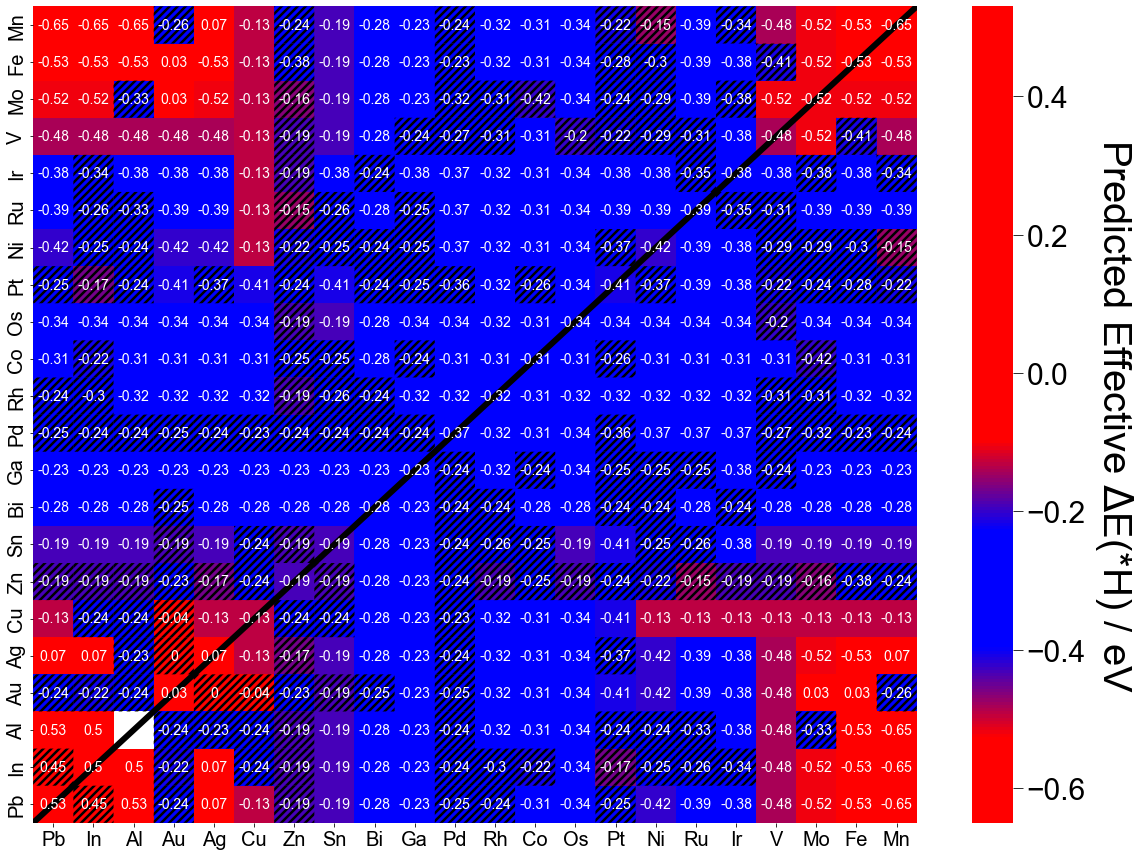

In [7]:
fig, ax = plt.subplots(figsize=(16, 12))
import matplotlib

norm = matplotlib.colors.Normalize(
    DF.adsorption_energy_H.min(), DF.adsorption_energy_H.max()
)
matplotlib.rcParams["hatch.linewidth"] = 2.5
colors = [
    [norm(DF.adsorption_energy_H.min()), "red"],
    [norm(-0.53), "red"],
    [norm(-0.4), "blue"],
    [norm(-0.23), "blue"],
    [norm(-0.1), "red"],
    [norm(DF.adsorption_energy_H.max()), "red"],
]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
# plt.title(
#     "Gridplot of the Composition Low-Coverage Site Nearest to -0.24 eV",
#     fontsize=22,
#     fontweight="bold"
# )
gp, gridplot_ordering = gridplot_from_components(
    DF.copy().drop(["mpid_A", "mpid_B"], axis=1),
    ordering="ssq-dG",
    ax=ax,
    cmap=cmap,
    annot_fontsize=14,
    hatch_bimetallic=True,
    # cbar_kws={'ticks':[-0.1, -0.2, -0.3, -0.4, -0.5, -0.6]},
)
gp.collections[0].colorbar.set_label(
    "Predicted Effective $\Delta$E(*H) / eV", size=40, rotation=270
)
gp.collections[0].colorbar.ax.tick_params(labelsize=30, size=10)
plt.plot([len(gridplot_ordering), 0], [0, len(gridplot_ordering)], "k", linewidth=6)
plt.tight_layout()
gp.collections[0].colorbar.ax.yaxis.labelpad = 50
fig.savefig(
    fname="../figures/gridplot_fig/gridplot_fig.pdf", bbox_inches="tight", dpi=300
)

In [8]:
(
    (DF.adsorption_energy_H.dropna() < -0.23)
    & (DF.adsorption_energy_H.dropna() > -0.41)
).mean()

0.6031746031746031

In [9]:
(
    (DF[DF.bimetallic_mpid].dropna().adsorption_energy_H < -0.23)
    & (DF[DF.bimetallic_mpid].dropna().adsorption_energy_H > -0.41)
).mean()

0.7032967032967034

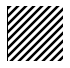

In [10]:
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(figsize=(1, 1))
ax.axis("off")
ax.add_patch(
    Rectangle(
        (0, 0),
        1.5,
        1.5,
        hatch="///",
        fill=False,
    )
)
fig.savefig("../figures/gridplot_fig/hatching.pdf", bbox_inches="tight", dpi=300)